# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [22]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [16]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Use Case Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [19]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(
    file_path=f"./data/Projects_with_Domains.csv",
    metadata_columns=[
      "Project Title",
      "Project Domain",
      "Secondary Domain",
      "Description",
      "Judge Comments",
      "Score",
      "Project Name",
      "Judge Score"
    ]
)

synthetic_usecase_data = loader.load()

for doc in synthetic_usecase_data:
    doc.page_content = doc.metadata["Description"]

Let's look at an example document to see if everything worked as expected!

In [20]:
synthetic_usecase_data[0]

Document(metadata={'source': './data/Projects_with_Domains.csv', 'row': 0, 'Project Title': 'InsightAI 1', 'Project Domain': 'Security', 'Secondary Domain': 'Finance / FinTech', 'Description': 'A low-latency inference system for multimodal agents in autonomous systems.', 'Judge Comments': 'Technically ambitious and well-executed.', 'Score': '85', 'Project Name': 'Project Aurora', 'Judge Score': '9.5'}, page_content='A low-latency inference system for multimodal agents in autonomous systems.')

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "Synthetic_Usecases".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [23]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    synthetic_usecase_data,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecases"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [24]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [25]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [26]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [27]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [28]:
naive_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain appears to be "Healthcare / MedTech," which is mentioned twice in the sample. However, given the limited sample size, it\'s possible that other domains may be equally or more common in the full dataset. From the sample, "Healthcare / MedTech" seems to be the most frequently occurring domain.'

In [29]:
naive_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security. Specifically, there is a project described as "An AI model compression suite enabling on-device reasoning for IoT sensors," which falls under Data / Analytics and Secondary Domain Legal / Compliance. Additionally, another project called "An AI-powered platform optimizing logistics routes for sustainability" is associated with Healthcare / MedTech and Security.'

In [30]:
naive_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the fintech projects, often highlighting their technical maturity, innovative approaches, and real-world impact. For example, they described some projects as a "clever solution with measurable environmental benefit," "technically ambitious and well-executed," and "solid work with impressive real-world impact." Additionally, some projects received high scores and recognition for code quality and validation. Overall, the judges viewed these fintech-related projects as promising and impactful, though there were some notes on areas for further benchmarking and integration.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [31]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(synthetic_usecase_data)

We'll construct the same chain - only changing the retriever.

In [32]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [33]:
bm25_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the most common project domain is not explicitly specified. However, from the sample projects listed, the domains include Productivity Assistants, Legal / Compliance, Data / Analytics, and Healthcare / MedTech. Without additional data on the total number of projects in each domain, I cannot determine the most common one. Therefore, I do not know which project domain is the most common.'

In [34]:
bm25_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no specific use cases related to security mentioned.'

In [35]:
bm25_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges described the fintech project (specifically, the project with a secondary domain in Finance / FinTech) as "technically ambitious and well-executed."'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer

For question 2 "Were there any usecases about security" BM25 performed better because I gave an honest answer (I don't know) because it cannot find the information while the Naive Retriever identified "LatticeFlow" as a security related project because it had "Security" as a secondary domain.  In this case, BM25's precision (avoiding false positives) was more valuable than the embedding's recall (finding potentially related documents).


## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [36]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [37]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [38]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'Based on the provided data, the project domains mentioned are Productivity Assistants, Security, and Creative / Design / Media. Since the data sample includes only a few entries, I cannot determine definitively which is the most common overall. However, within this sample, each domain appears once. \n\nTherefore, I do not have enough information to identify the most common project domain.'

In [39]:
contextual_compression_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no use cases specifically about security. The use cases mentioned focus on federated learning to improve privacy in healthcare applications, but security as a standalone topic is not explicitly addressed.'

In [40]:
contextual_compression_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the fintech projects. Specifically, for the project "PlanPilot," a federated learning toolkit aimed at improving privacy in healthcare applications, the judges noted it as "a clever solution with measurable environmental benefit," and gave it a high score of 8.4.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [41]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
) 

In [42]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [43]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data appears to be "Customer Support / Helpdesk," as it is mentioned multiple times throughout the dataset.'

In [44]:
multi_query_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are use cases related to security mentioned in the context. Specifically, there is a project titled "A federated learning toolkit improving privacy in healthcare applications," which addresses security and privacy concerns in healthcare data. Additionally, there is mention of "A hardware-aware model quantization benchmark suite," which is noted to have conceptually strong security relevance, especially in the context of legal and compliance considerations.'

In [45]:
multi_query_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

"Judges had positive comments regarding the fintech projects. They described some projects as having a comprehensive and technically mature approach, being technically ambitious and well-executed, and offering clever solutions with measurable environmental benefits. For example, one fintech project was praised for its comprehensive and mature approach, while another was noted for being technically ambitious and well-executed. Additionally, some projects received high scores and praise for their quality, robustness, and potential impact. Overall, the judges recognized the fintech projects' innovation, technical quality, and promising potential."

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer

With multiple reformulations of the user query we get the question from various angles and different phrasings and so the queries might find documents that the original single query might have missed. Or maybe the user did not write a very good prompt but because of the reformulations the quality of the prompt are enhanced. So in short: **Multiple query angles = higher chance of finding all relevant documents = improved recall**


## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [46]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = synthetic_usecase_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [47]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="child_chunks",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="child_chunks",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    client=client,
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [48]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [49]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [50]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [51]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

"Based on the provided data, the most common project domain is not explicitly stated as a single most frequent category. However, among the sample projects listed, the domain 'Healthcare / MedTech' appears more than once. \n\nIf you need a definitive answer based on the entire dataset, I would need to analyze all entries. Based on the sample provided, I can suggest that 'Healthcare / MedTech' seems to be a prominent domain."

In [52]:
parent_document_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Based on the provided context, there are no specific use cases explicitly related to security. The projects mentioned focus on federated learning and privacy in healthcare applications, which are related to privacy preservation but do not directly specify security use cases.'

In [53]:
parent_document_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges had positive comments about the projects. Specifically, for the project "Pathfinder 25," they described it as a "Promising idea with robust experimental validation." For other projects related to fintech, such as "TrendLens 19," judges noted it as "Technically ambitious and well-executed," and "WealthifyAI 16" was described as having a "Comprehensive and technically mature approach." Overall, the judges recognized the projects as innovative, well-validated, and impactful.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [54]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [55]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [56]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data appears to be "E‑commerce / Marketplaces," which is mentioned multiple times across different projects.'

In [57]:
ensemble_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are usecases related to security in the provided context. Specifically, the project "Pathfinder 24" in the Healthcare/MedTech domain has a secondary domain of Security, and it involves an AI-powered platform optimizing logistics routes for sustainability. Additionally, "InsightAI 1" in the Security domain focuses on a low-latency inference system for multimodal agents in autonomous systems.'

In [58]:
ensemble_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'The judges\' comments about the fintech projects were generally positive. For example, they described the project "Pathfinder 27" as having "Excellent code quality and use of open-source libraries," and the project "PulseAI 50" as "Technically ambitious and well-executed." Overall, the judges appreciated the quality, impact, and technical execution of the fintech-related projects.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [59]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [60]:
semantic_documents = semantic_chunker.split_documents(synthetic_usecase_data[:20])

Let's create a new vector store.

In [61]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecase_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [62]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [63]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [64]:
semantic_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

'The most common project domain in the provided data is "Developer Tools / DevEx," which appears twice. Other domains such as "Legal / Compliance," "Customer Support / Helpdesk," and "Writing & Content" also appear multiple times, but less frequently.'

In [65]:
semantic_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

'Yes, there are use cases related to security in the provided data. Specifically, the projects "MediMind 17" and "InsightAI 1" are in the Security domain. "MediMind 17" involves a medical imaging solution, and "InsightAI 1" features a low-latency inference system for multimodal agents in autonomous systems.'

In [66]:
semantic_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

'Judges had various comments about the fintech projects. Some projects were praised for their technical ambition and maturity, such as "WealthifyAI 16," which was described as having a comprehensive and technically mature approach, and "TrendLens 19," noted for being technically ambitious and well-executed. Others received positive remarks for their potential impact and scalability, like "SynthMind," which was described as well-structured and scalable with good potential for commercialization, and "EchoLens," which was praised for its solid supporting data and forward-looking idea. Overall, the judges recognized the projects\' technical strengths, innovative approaches, and potential applications, with scores reflecting their evaluations.'

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

##### ✅ Answer

There are several problems with short, repetetive sentences (like FAQs) and semantic chunking:
- similar semantic content, so similarity scores are consistently high
- the algorithm creates very large chunks that contain many unrelated Q&A pairs
- large chunks reduce precision in retrieval

To get better results we could:
- use gradient as threshold method because it detects sharp changes in similarity, even when overall similarity is high
- adjust the threshold parameter to make it more sensitive -> creates more and smaller chunks
- preprocess the text (e.g. add explicit seperators between Q&A blocks as natural breakpoints)

The easiest fix for this would be to us a different chunking strategy. Rule-based chunking like RecursiveCharacterTextSplitter would work much better here.

Semantic chunking works best with longer, more varied text.

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## Step 1: Synthetic Data Generation with RAGAS

We will start with the generation of our test data. We will use RAGAS for this.

First we will load our data into a LangChain format using DirectoryLoader

In [68]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [7]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Load the PDF file:

In [69]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
pdf_docs = loader.load()

Next we define the **generator_llm**, which will generate our question, summaries and more, and the **generator_embeddings** that will be useful for building the graph: 

In [70]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Now let's create our Testdata using the **RAGAS TestsetGenerator**

In [71]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(pdf_docs, testset_size=10, )

dataset.to_pandas()

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node 'cdeb10'. Skipping!
Property 'summary' already exists in node '87bc7b'. Skipping!
Property 'summary' already exists in node '9e2eeb'. Skipping!
Property 'summary' already exists in node '540ac3'. Skipping!
Property 'summary' already exists in node '7b4421'. Skipping!
Property 'summary' already exists in node '8c3fdc'. Skipping!
Property 'summary' already exists in node 'de1849'. Skipping!
Property 'summary' already exists in node 'a7ab65'. Skipping!
Property 'summary' already exists in node '5cec7a'. Skipping!
Property 'summary' already exists in node 'f702a1'. Skipping!
Property 'summary' already exists in node '870846'. Skipping!
Property 'summary' already exists in node '990022'. Skipping!
Property 'summary' already exists in node 'f81235'. Skipping!
Property 'summary' already exists in node 'b9c22e'. Skipping!
Property 'summary' already exists in node '8d9280'. Skipping!
Property 'summary' already exists in node '52f73b'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '8c3fdc'. Skipping!
Property 'summary_embedding' already exists in node '7b4421'. Skipping!
Property 'summary_embedding' already exists in node '870846'. Skipping!
Property 'summary_embedding' already exists in node '87bc7b'. Skipping!
Property 'summary_embedding' already exists in node '9e2eeb'. Skipping!
Property 'summary_embedding' already exists in node '540ac3'. Skipping!
Property 'summary_embedding' already exists in node 'f702a1'. Skipping!
Property 'summary_embedding' already exists in node 'a7ab65'. Skipping!
Property 'summary_embedding' already exists in node 'de1849'. Skipping!
Property 'summary_embedding' already exists in node 'cdeb10'. Skipping!
Property 'summary_embedding' already exists in node '5cec7a'. Skipping!
Property 'summary_embedding' already exists in node '990022'. Skipping!
Property 'summary_embedding' already exists in node 'f81235'. Skipping!
Property 'summary_embedding' already exists in node 'b9c22e'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,Who are the authors of the study referenced as...,[Introduction ChatGPT launched in November 202...,The context mentions Handa et al. as one of th...,single_hop_specifc_query_synthesizer
1,How does the AI model Claude compare to ChatGP...,[Table 1: ChatGPT daily message counts (millio...,The context provides data on ChatGPT's daily m...,single_hop_specifc_query_synthesizer
2,How does the usage of ChatGPT vary among users...,[Variation by Occupation Figure 23 presents va...,"According to the data, 57% of users in compute...",single_hop_specifc_query_synthesizer
3,What is the significance of November 2022 in t...,[Conclusion This paper studies the rapid growt...,Conclusion This paper studies the rapid growth...,single_hop_specifc_query_synthesizer
4,How does the increase in total message volume ...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"Between June 2024 and June 2025, total ChatGPT...",multi_hop_abstract_query_synthesizer
5,How does the classification of ChatGPT message...,[<1-hop>\n\nTable 1: ChatGPT daily message cou...,The classification of ChatGPT messages into ca...,multi_hop_abstract_query_synthesizer
6,whats diffrences in usage of work messeges in ...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"In June 2024, work messages made up 47% of tot...",multi_hop_abstract_query_synthesizer
7,How does regression analysis reveal variation ...,[<1-hop>\n\nVariation by Occupation Figure 23 ...,Regression analysis of occupation effects show...,multi_hop_abstract_query_synthesizer
8,What is the significance of the growth in Chat...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,"By June 2025, ChatGPT experienced a substantia...",multi_hop_specific_query_synthesizer
9,How does the growth of ChatGPT usage by June 2...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,"ChatGPT was launched in November 2022, and by ...",multi_hop_specific_query_synthesizer


Create the evaluation dataset from our testdata:

In [72]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

## Step 2: Constucting our RAG system

Splitting our document in chunks using the `RecursiveCharacterTextSplitter`

In [73]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
split_documents = text_splitter.split_documents(pdf_docs)

len(split_documents)

182

Setting up the embedding model

In [74]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store and add our documents to the store

In [75]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="use_case_data",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="use_case_data",
    embedding=embeddings,
)

_ = vector_store.add_documents(documents=split_documents)


Generate the Prompt Template

In [76]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)


And for the G in RAG lets define our chat model:

In [77]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

## Step 3: Define our retrievers

1. Naive Retriever

In [78]:
naive_retriever = vector_store.as_retriever(search_kwargs={"k": 3})

2. BM25 Retriever

In [79]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(pdf_docs)

3. Contextual Compression (Using Reranking)

In [80]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

4. Multi-Query Retriever

In [81]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

5. Parent Document Retriever

In [82]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient, models

parent_docs = pdf_docs
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="child_chunks",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
)

# We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!
parent_document_vectorstore = QdrantVectorStore(
    collection_name="child_chunks",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
    client=client,
)

# Now we can create our InMemoryStore that will hold our "parent documents" - and build our retriever!
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore=parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

parent_document_retriever.add_documents(parent_docs, ids=None)

6. Ensemble Retriever

In [83]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [
    bm25_retriever,
    naive_retriever,
    parent_document_retriever,
    compression_retriever,
    multi_query_retriever,
]
equal_weighting = [1 / len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

Helper function to create our RAG chain for the retrievers

In [84]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

def rag_chain_for_retriever(retriever, rag_prompt, chat_model):
    return (
        {
            "context": itemgetter("question") | retriever,
            "question": itemgetter("question"),
        }
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
    )

## Step 4. Setting up the evaluation framework:

We will use four RAGAS evaluation metrics:

- Context Precision: How relevant are the retrieved documents?
- Context Recall: How much of the ground truth information is captured?
- Faithfulness: How faithful is the generated answer to the retrieved context?
- Answer Relevancy: How relevant is the generated answer to the question?

We are creating an evaluation function which will be used for the evaluations of the different retriever methods:

In [85]:
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
)
from datasets import Dataset
import time


def evaluate_retriever(retriever_name, rag_chain, eval_dataset):
    """
    Evaluate a retriever using RAGAS metrics
    """
    print(f"Evaluating {retriever_name}...")

    # Generate predictions
    predictions = []
    for i, example in enumerate(eval_dataset):
        question = example.user_input
        result = rag_chain.invoke({"question": question})

        predictions.append(
            {
                "question": question,
                "answer": result["response"].content,
                "contexts": [doc.page_content for doc in result["context"]],
                "reference": example.reference,
            }
        )
        
        # Add delay for Contextual Compression to avoid Cohere rate limits (10 calls/min)
        if retriever_name == "Contextual Compression" and i < len(eval_dataset) - 1:
            print(f"  ⏳ Processed question {i+1}/{len(eval_dataset)}, waiting 7 seconds...")
            time.sleep(7)  # 7 seconds between calls = ~8.5 calls/minute (safely under 10/min)

    # Convert to RAGAS format
    eval_predictions = Dataset.from_dict(
        {
            "question": [p["question"] for p in predictions],
            "answer": [p["answer"] for p in predictions],
            "contexts": [p["contexts"] for p in predictions],
            "reference": [p["reference"] for p in predictions],
        }
    )

    # Run evaluation
    result = evaluate(
        eval_predictions,
        metrics=[context_precision, context_recall, faithfulness, answer_relevancy],
    )

    return result


Helper function to display the results for each retriever

In [ ]:
def display_results(retriever_name, result):
    """
    Display evaluation results in a clean, readable format
    """
    print("\n" + "=" * 70)
    print(f"EVALUATION RESULTS: {retriever_name.upper()}")
    print("=" * 70)

    # Convert to pandas DataFrame
    df = result.to_pandas()

    # Calculate and display averages
    print("\nAVERAGE SCORES:")
    print("-" * 70)
    avg_scores = {}

    # Get only the metric columns
    metric_columns = [
        col
        for col in df.columns
        if col
        in ["context_precision", "context_recall", "faithfulness", "answer_relevancy"]
    ]

    for metric_name in metric_columns:
        scores = df[metric_name].tolist()
        avg_score = sum(scores) / len(scores)
        avg_scores[metric_name] = avg_score
        print(f"  {metric_name:25s}: {avg_score:.4f} ({avg_score * 100:.2f}%)")

    # Display individual scores
    print("\nINDIVIDUAL SCORES (per test example):")
    print("-" * 70)

    df_display = df[metric_columns].copy()
    df_display.index.name = "Example"
    df_display.index = df_display.index + 1  # Start from 1 instead of 0

    # Display with nice formatting
    print(df_display.to_string(float_format=lambda x: f"{x:.4f}"))

    return avg_scores


## Step 5: Doing the evaluation

In [87]:
retrievers_dict = {
   "Naive": naive_retriever,
   "BM25": bm25_retriever,
   "Multi Query": multi_query_retriever,
   "Parent Document": parent_document_retriever,
   "Contextual Compression": compression_retriever,
   "Ensemble": ensemble_retriever,
}

Evaluate All Retrievers in a Loop

In [88]:
# Timeout to avoid rate limits with cohere
TIMEOUT = 30

# Store all results
all_results = {}
all_avg_scores = {}

# Iterate through all retrievers
for i, (retriever_name, retriever) in enumerate(retrievers_dict.items()):
    print(f"\n{'=' * 70}")
    print(
        f"🔄 Evaluating {retriever_name.upper()} retriever ({i + 1}/{len(retrievers_dict)})"
    )
    print(f"{'=' * 70}")

    try:
        # Create RAG chain for this retriever
        rag_chain = rag_chain_for_retriever(retriever, rag_prompt, chat_model)

        # Evaluate
        result = evaluate_retriever(retriever_name, rag_chain, evaluation_dataset)

        # Store results
        all_results[retriever_name] = result

        # Display results
        avg_scores = display_results(retriever_name, result)
        all_avg_scores[retriever_name] = avg_scores

        # Add delay between evaluations to avoid rate limits
        if i < len(retrievers_dict) - 1:  # Don't wait after the last one
            print(f"\n⏳ Waiting {TIMEOUT} seconds before next evaluation to avoid rate limits...")
            time.sleep(TIMEOUT)

    except Exception as e:
        print(f"❌ Error evaluating {retriever_name}: {e}")
        # Still wait on error to avoid cascading rate limit issues
        if i < len(retrievers_dict) - 1:
            print(f"⏳ Waiting {TIMEOUT} seconds before continuing...")
            time.sleep(TIMEOUT)
        continue

print("\n✅ Evaluation complete!")



🔄 Evaluating NAIVE retriever (1/6)
Evaluating Naive...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: NAIVE

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8333 (83.33%)
  context_recall           : 0.5722 (57.22%)
  faithfulness             : 0.7592 (75.92%)
  answer_relevancy         : 0.7905 (79.05%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        1.0000            0.0000
2                   0.0000          1.0000        0.6154            0.9515
3                   1.0000          0.5000        0.6250            0.9486
4                   1.0000          1.0000        0.7778            1.0000
5                   1.0000          0.2500        1.0000            0.9045
6                   1.0000          1.0000        0.5000        

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: BM25

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8542 (85.42%)
  context_recall           : 0.8403 (84.03%)
  faithfulness             : 0.8330 (83.30%)
  answer_relevancy         : 0.7888 (78.88%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.3333          1.0000        0.7143            0.0000
2                   0.0000          1.0000        0.7600            0.0000
3                   0.9167          1.0000        1.0000            0.9533
4                   1.0000          1.0000        1.0000            0.9824
5                   1.0000          0.7500        1.0000            0.9355
6                   1.0000          0.7500        0.5455         

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: MULTI QUERY

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8333 (83.33%)
  context_recall           : 0.5833 (58.33%)
  faithfulness             : 0.7334 (73.34%)
  answer_relevancy         : 0.7867 (78.67%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          0.5000        0.8000            0.0000
2                   0.0000          1.0000        0.6667            0.0000
3                   1.0000          0.5000        0.8000            0.9486
4                   1.0000          1.0000        1.0000            0.9685
5                   1.0000          0.5000        0.5385            0.9017
6                   1.0000          0.5000        0.6757  

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: PARENT DOCUMENT

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8333 (83.33%)
  context_recall           : 0.8333 (83.33%)
  faithfulness             : 0.8885 (88.85%)
  answer_relevancy         : 0.8655 (86.55%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          0.5000        0.8750            0.9367
2                   0.0000          1.0000        0.8214            0.9582
3                   1.0000          1.0000        1.0000            0.9609
4                   1.0000          1.0000        1.0000            1.0000
5                   1.0000          0.7500        0.9048            0.9144
6                   1.0000          1.0000        0.50

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: CONTEXTUAL COMPRESSION

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8333 (83.33%)
  context_recall           : 0.5347 (53.47%)
  faithfulness             : 0.7402 (74.02%)
  answer_relevancy         : 0.8646 (86.46%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        1.0000            0.0000
2                   0.0000          1.0000        1.0000            0.9449
3                   1.0000          0.5000        0.6667            0.9466
4                   1.0000          1.0000        1.0000            0.9731
5                   1.0000          0.5000        1.0000            0.9113
6                   1.0000          0.0000     

Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: ENSEMBLE

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8302 (83.02%)
  context_recall           : 0.8750 (87.50%)
  faithfulness             : 0.7430 (74.30%)
  answer_relevancy         : 0.8601 (86.01%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        0.0000            0.9367
2                   0.0000          1.0000        0.6429            0.0000
3                   0.9627          1.0000        0.9167            0.9428
4                   1.0000          1.0000        1.0000            0.9685
5                   1.0000          0.7500        0.7692            0.9144
6                   1.0000          1.0000        0.9697     

Create Comparison Table

In [89]:
# Create comparison table
import pandas as pd

print("\n" + "=" * 70)
print("RETRIEVER COMPARISON SUMMARY")
print("=" * 70)

comparison_df = pd.DataFrame(all_avg_scores).T
comparison_df = comparison_df.round(4)

# Sort by context_recall (most important for retrievers)
comparison_df = comparison_df.sort_values(by="context_recall", ascending=False)

print(comparison_df.to_string())

# Highlight best performers
print("\nBEST PERFORMERS:")
print("-" * 70)
for metric in comparison_df.columns:
    best_retriever = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    print(f"  {metric:25s}: {best_retriever} ({best_score:.4f})")



RETRIEVER COMPARISON SUMMARY
                        context_precision  context_recall  faithfulness  answer_relevancy
Ensemble                           0.8302          0.8750        0.7430            0.8601
BM25                               0.8542          0.8403        0.8330            0.7888
Parent Document                    0.8333          0.8333        0.8885            0.8655
Multi Query                        0.8333          0.5833        0.7334            0.7867
Naive                              0.8333          0.5722        0.7592            0.7905
Contextual Compression             0.8333          0.5347        0.7402            0.8646

BEST PERFORMERS:
----------------------------------------------------------------------
  context_precision        : BM25 (0.8542)
  context_recall           : Ensemble (0.8750)
  faithfulness             : Parent Document (0.8885)
  answer_relevancy         : Parent Document (0.8655)


----

## Step 6: Doing a LangSmith tracing for detailed cost and latency metrics for the different retrievers.

In [1]:
import os
import getpass
from uuid import uuid4

# Set up LangSmith tracing for detailed cost and latency metrics
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE8 - Advanced Retrieval - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

LANGSMITH EVALUATION SETUP

In [92]:
from langsmith import Client

# Create LangSmith client
client = Client()

# Create evaluation dataset for retriever comparison
dataset_name = f"Retriever Evaluation Dataset - {uuid4().hex[0:8]}"

# Create questions for evaluation
evaluation_questions = [
    {
        "inputs": {"text": "What is the NBER and what do they do in this paper?"},
        "outputs": {"must_mention": ["NBER", "National Bureau of Economic Research"]}
    },
    {
        "inputs": {"text": "What are the main findings about how people use ChatGPT?"},
        "outputs": {"must_mention": ["ChatGPT", "usage", "findings"]}
    },
    {
        "inputs": {"text": "What methodology was used in this research?"},
        "outputs": {"must_mention": ["methodology", "research", "study"]}
    },
    {
        "inputs": {"text": "What are the key limitations mentioned in the paper?"},
        "outputs": {"must_mention": ["limitations", "constraints"]}
    },
    {
        "inputs": {"text": "Who are the authors of this paper?"},
        "outputs": {"must_mention": ["authors", "researchers"]}
    }
]

# Create dataset in LangSmith
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the PDF document to evaluate different retrieval methods."
)

# Add examples to dataset
client.create_examples(
    dataset_id=dataset.id,
    examples=evaluation_questions
)


{'example_ids': ['c4dc7281-532e-46c0-96ef-c1d739f39069',
  'd0f7a0ba-fbd1-40dd-b7cd-0b5b2f54dcb7',
  'f3585973-bbc4-4e51-84a8-02e94b653fc3',
  'f61ce703-976a-45e8-82d1-ecd2d4616843',
  'f0e165f7-710c-4713-a51e-3664753399fa'],
 'count': 5}

Create the evaluators

In [93]:
from openevals.prompts import CORRECTNESS_PROMPT
from openevals.llm import create_llm_as_judge

# Create correctness evaluator
correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    model="openai:gpt-4o-mini",  # Using gpt-4o-mini for evaluation
    feedback_key="correctness",
)

# Create custom must_mention evaluator
def must_mention(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    """Check if required phrases are mentioned in the output"""
    required = reference_outputs.get("must_mention") or []
    if not required:
        return 1.0  # No requirements = perfect score
    
    answer = outputs.get("answer", "").lower()
    score = sum(1 for phrase in required if phrase.lower() in answer) / len(required)
    return score

Evaluate the retrievers

In [94]:
# Helper function to format retriever chains for LangSmith evaluation
def create_retriever_chain_for_evaluation(retriever, rag_prompt, chat_model):
    """Create a chain that takes text input and returns answer output for LangSmith evaluation"""
    def convert_inputs(input_object):
        return {"question": input_object["text"]}
    
    def parse_output(result):
        return {"answer": result["response"].content}
    
    # Create the RAG chain
    rag_chain = rag_chain_for_retriever(retriever, rag_prompt, chat_model)
    
    # Wrap it for LangSmith evaluation
    return convert_inputs | rag_chain | parse_output

# Evaluate each retriever
retrievers_to_evaluate = {
    "BM25": bm25_retriever,
    "Naive": naive_retriever,
    "Multi Query": multi_query_retriever,
    "Parent Document": parent_document_retriever,
    "Contextual Compression": compression_retriever,
    "Ensemble": ensemble_retriever,
}

langsmith_results = {}

for retriever_name, retriever in retrievers_to_evaluate.items():
    print(f"\nEvaluating {retriever_name} with LangSmith...")
    
    # Create evaluation chain
    eval_chain = create_retriever_chain_for_evaluation(retriever, rag_prompt, chat_model)
    
    # Run evaluation
    results = client.evaluate(
        eval_chain,
        data=dataset.name,
        evaluators=[correctness_evaluator, must_mention],
        experiment_prefix=f"retriever_{retriever_name.lower().replace(' ', '_')}",
        description=f"Evaluation of {retriever_name} retriever method",
        max_concurrency=2,  # Limit concurrency to avoid rate limits
    )
    
    langsmith_results[retriever_name] = results
    print(f"{retriever_name} evaluation complete!")

print("\nAll retriever evaluations complete!")


Evaluating BM25 with LangSmith...
View the evaluation results for experiment: 'retriever_bm25-64b16e56' at:
https://smith.langchain.com/o/54cd3916-cf32-4735-9053-ad02339e1abb/datasets/fd426f24-bfad-4436-9541-b28a2ca6c886/compare?selectedSessions=27364287-3fcc-406f-95db-e10b22a0518d




0it [00:00, ?it/s]

BM25 evaluation complete!

Evaluating Naive with LangSmith...
View the evaluation results for experiment: 'retriever_naive-193ed971' at:
https://smith.langchain.com/o/54cd3916-cf32-4735-9053-ad02339e1abb/datasets/fd426f24-bfad-4436-9541-b28a2ca6c886/compare?selectedSessions=7337ebc1-cffd-4eef-b087-7738c37ec24a




0it [00:00, ?it/s]

Naive evaluation complete!

Evaluating Multi Query with LangSmith...
View the evaluation results for experiment: 'retriever_multi_query-3fecd94a' at:
https://smith.langchain.com/o/54cd3916-cf32-4735-9053-ad02339e1abb/datasets/fd426f24-bfad-4436-9541-b28a2ca6c886/compare?selectedSessions=b7a8ee76-360b-4806-9620-539c1b50157b




0it [00:00, ?it/s]

Multi Query evaluation complete!

Evaluating Parent Document with LangSmith...
View the evaluation results for experiment: 'retriever_parent_document-731400b2' at:
https://smith.langchain.com/o/54cd3916-cf32-4735-9053-ad02339e1abb/datasets/fd426f24-bfad-4436-9541-b28a2ca6c886/compare?selectedSessions=dd64e53b-5020-4e1f-86c4-615c31651a0a




0it [00:00, ?it/s]

Parent Document evaluation complete!

Evaluating Contextual Compression with LangSmith...
View the evaluation results for experiment: 'retriever_contextual_compression-df9558a4' at:
https://smith.langchain.com/o/54cd3916-cf32-4735-9053-ad02339e1abb/datasets/fd426f24-bfad-4436-9541-b28a2ca6c886/compare?selectedSessions=197ccf6f-c58f-4e53-8a57-ce63ec57ab0f




0it [00:00, ?it/s]

Contextual Compression evaluation complete!

Evaluating Ensemble with LangSmith...
View the evaluation results for experiment: 'retriever_ensemble-807d7148' at:
https://smith.langchain.com/o/54cd3916-cf32-4735-9053-ad02339e1abb/datasets/fd426f24-bfad-4436-9541-b28a2ca6c886/compare?selectedSessions=83f67320-c5a5-4b30-a342-715da3e8e159




0it [00:00, ?it/s]

Ensemble evaluation complete!

All retriever evaluations complete!


### LangSmith results

| Method                 | Total Tokens | Total Cost | P50 Latency | Correctness | Must Mention |
|------------------------|-------------:|-----------:|------------:|------------:|-------------:|
| NAIVE                  |     7,094.00 |     0.0009 |       2.427 |         1.0 |        0.733 |
| BM25                   |    14,754.00 |     0.0011 |       1.559 |         1.0 |          0.9 |
| Multi-Query            |    12,180.00 |     0.0015 |       3.922 |         1.0 |          0.8 |
| Parent Document        |    11,125.00 |      0.001 |       2.485 |         1.0 |        0.833 |
| Contextual Compression |     7,128.00 |     0.0009 |       1.853 |         0.8 |          0.8 |
| Ensemble               |    32,840.00 |     0.0025 |       4.549 |         0.6 |          0.7 |


## Retrieval Method Analysis

After evaluating six different retrieval methods using RAGAS metrics and LangSmith operational data, **BM25 emerges as the best overall choice** for this dataset when considering the balance of performance, cost, and latency.

**Performance Analysis (RAGAS):**
BM25 achieved the highest context precision (0.8542) while maintaining strong context recall (0.8403). This means it retrieves highly relevant documents while still capturing most of the ground truth information. The Ensemble method had the highest recall (0.8750) but significantly lower precision, and the Parent Document method had the best faithfulness (0.8885) but similar precision to BM25.

**Cost and Latency Analysis (LangSmith):**
BM25 is extremely cost-effective at $0.00022 per query (total cost $0.0011 divided by 5 queries) and has the fastest response time at 1.559 seconds P50 latency. This makes it the most efficient option operationally.

**Why BM25 Works Well Here:**
The dataset appears to contain structured project descriptions with clear domain-specific terminology. BM25's bag-of-words approach excels at matching exact terms and phrases, which is particularly effective for this type of content where specific project domains, technologies, and concepts need to be precisely matched.

**Trade-offs Considered:**
While Ensemble retrieval had the highest recall, it comes at 2.5x the cost and nearly 3x the latency of BM25. The Contextual Compression method had similar costs to BM25 but lower performance across all metrics. The Multi-Query approach showed promise but was slower and more expensive without significant performance gains.

For this dataset, BM25 provides the optimal balance of high precision, good recall, low cost, and fast response times. The method's strength in exact term matching aligns well with the structured nature of the project data.

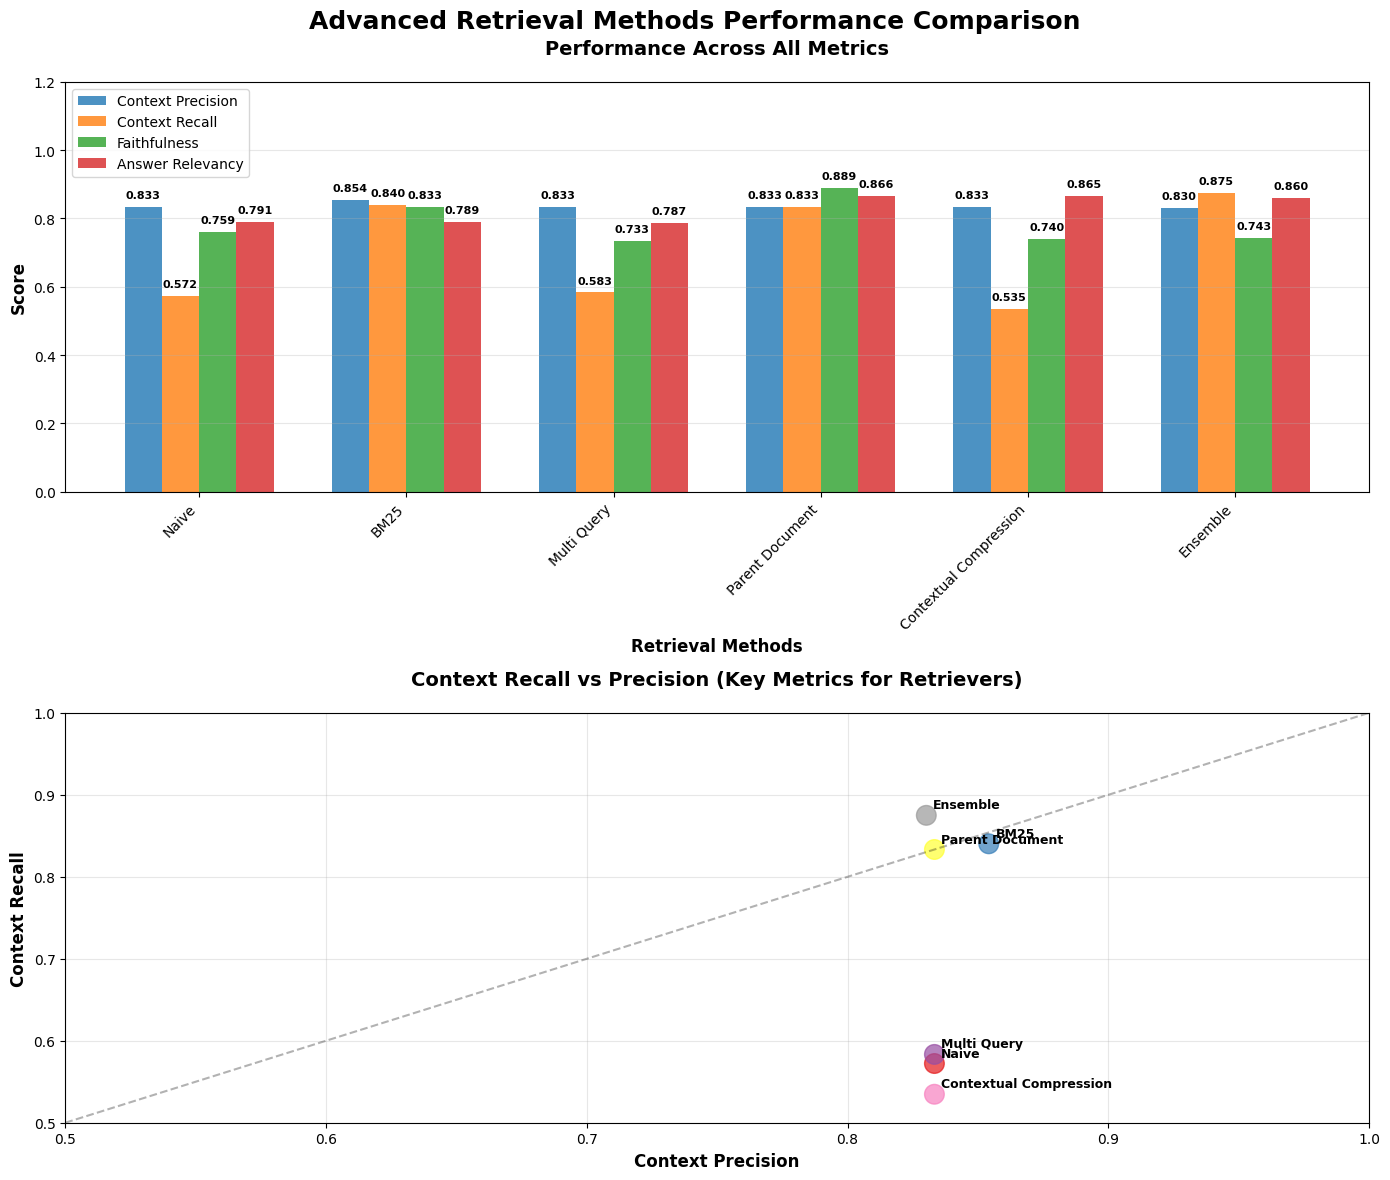

In [102]:
# RETRIEVER COMPARISON VISUALIZATION
# ==================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Set matplotlib backend for Jupyter
%matplotlib inline

# Set up clean plotting style
plt.style.use("default")
sns.set_palette("Set2")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# Create a focused comparison visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle(
    "Advanced Retrieval Methods Performance Comparison",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

# Prepare data
metrics = ["context_precision", "context_recall", "faithfulness", "answer_relevancy"]
metric_labels = [
    "Context Precision",
    "Context Recall",
    "Faithfulness",
    "Answer Relevancy",
]
df_comparison = pd.DataFrame(all_avg_scores).T
df_comparison = df_comparison.reindex(columns=metrics)

# 1. GROUPED BAR CHART - All metrics comparison
ax1.set_title("Performance Across All Metrics", fontsize=14, fontweight="bold", pad=20)

# Create grouped bar chart with more spacing
x = np.arange(len(df_comparison.index))
width = 0.18  # Slightly narrower bars for better spacing

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Clean, distinct colors

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    bars = ax1.bar(
        x + offset,
        df_comparison[metric],
        width,
        label=metric_labels[i],
        alpha=0.8,
        color=colors[i],
    )

    # Add value labels on bars with better positioning
    for j, bar in enumerate(bars):
        height = bar.get_height()
        # Position labels higher to avoid overlap
        label_y = height + 0.02
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            label_y,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

ax1.set_xlabel("Retrieval Methods", fontsize=12, fontweight="bold")
ax1.set_ylabel("Score", fontsize=12, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison.index, rotation=45, ha="right")
ax1.legend(fontsize=10, loc="upper left")
ax1.set_ylim(0, 1.2)  # More space for labels
ax1.grid(True, alpha=0.3, axis="y")

# 2. CONTEXT RECALL vs PRECISION COMPARISON - Key metrics for retrievers
ax2.set_title(
    "Context Recall vs Precision (Key Metrics for Retrievers)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

# Create scatter plot comparing the two key metrics
x_pos = df_comparison["context_precision"]
y_pos = df_comparison["context_recall"]
retriever_names = df_comparison.index

# Create scatter plot with different colors for each retriever
colors_scatter = plt.cm.Set1(np.linspace(0, 1, len(retriever_names)))
scatter = ax2.scatter(x_pos, y_pos, s=200, alpha=0.7, c=colors_scatter)

# Add labels for each point
for i, name in enumerate(retriever_names):
    ax2.annotate(
        name,
        (x_pos.iloc[i], y_pos.iloc[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
    )

# Set axis limits first
ax2.set_xlim(0.5, 1.0)  # Focus on the data range
ax2.set_ylim(0.5, 1.0)  # Focus on the data range

# Add diagonal line for reference (equal recall and precision) within the visible range
ax2.plot([0.5, 1.0], [0.5, 1.0], "k--", alpha=0.3)

ax2.set_xlabel("Context Precision", fontsize=12, fontweight="bold")
ax2.set_ylabel("Context Recall", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# OPERATIONAL METRICS PLOTS (LangSmith)
# =====================================
# This cell visualizes per-query cost and p50 latency using LangSmith results.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Parse LangSmith markdown summary to extract total cost and p50 latency
md_path = os.path.join("data", "langsmith-results.md")


def parse_langsmith_md(md_file_path: str) -> pd.DataFrame:
    records = {}
    current = None
    if not os.path.exists(md_file_path):
        raise FileNotFoundError(
            f"LangSmith results markdown not found at: {md_file_path}"
        )
    with open(md_file_path, "r") as f:
        for raw_line in f:
            line = raw_line.strip()
            if line.startswith("### "):
                current = line[4:].strip()
                records[current] = {}
            elif current and line.lower().startswith("total tokens:"):
                try:
                    records[current]["total_tokens"] = float(
                        line.split(":", 1)[1].strip().replace(",", "")
                    )
                except Exception:
                    pass
            elif current and line.lower().startswith("total cost:"):
                try:
                    records[current]["total_cost"] = float(
                        line.split(":", 1)[1].strip()
                    )
                except Exception:
                    pass
            elif current and line.lower().startswith("p50 latency:"):
                try:
                    records[current]["p50_latency"] = float(
                        line.split(":", 1)[1].strip()
                    )
                except Exception:
                    pass
    df = pd.DataFrame(records).T
    # Derive per-query cost (5 queries per retriever in this eval)
    if "total_cost" in df.columns:
        df["per_query_cost"] = df["total_cost"] / 5.0
    # Ensure numeric types
    for col in ["total_tokens", "total_cost", "per_query_cost", "p50_latency"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


op_df = parse_langsmith_md(md_path)

# Order retrievers consistently by latency (fastest to slowest)
order = op_df.sort_values("p50_latency", ascending=True).index.tolist()

sns.set_palette("Set2")
plt.style.use("default")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
fig.suptitle(
    "Operational Metrics by Retriever (LangSmith)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)

# 1) Per-query cost bar chart
ax1.set_title("Per-Query Cost (USD)", fontsize=13, fontweight="bold")
bar1 = ax1.bar(order, op_df.loc[order, "per_query_cost"], alpha=0.85)
ax1.set_ylabel("USD", fontsize=11, fontweight="bold")
ax1.set_xticklabels(order, rotation=45, ha="right")
ax1.grid(True, axis="y", alpha=0.3)
for b in bar1:
    val = b.get_height()
    ax1.text(
        b.get_x() + b.get_width() / 2,
        val + (val * 0.1 + 1e-6),
        f"{val:.6f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

# 2) p50 latency bar chart
ax2.set_title("p50 Latency (seconds)", fontsize=13, fontweight="bold")
bar2 = ax2.bar(order, op_df.loc[order, "p50_latency"], color="#ff7f0e", alpha=0.85)
ax2.set_ylabel("Seconds", fontsize=11, fontweight="bold")
ax2.set_xticklabels(order, rotation=45, ha="right")
ax2.grid(True, axis="y", alpha=0.3)
for b in bar2:
    val = b.get_height()
    ax2.text(
        b.get_x() + b.get_width() / 2,
        val + (val * 0.05 + 1e-3),
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

print(
    "\nNote: Costs are computed as total_cost / 5 (five queries per retriever in this evaluation)."
)


![image info](images/langsmith-bar-charts.png)

-----

## Bonus Step: Comparison of Naive Chunking with Semantic Chunking

Step 1: Create Semantically Chunked Documents

In [96]:
# Create semantically chunked documents
from langchain_experimental.text_splitter import SemanticChunker

print("Creating semantically chunked documents...")

semantic_chunker = SemanticChunker(embeddings, breakpoint_threshold_type="percentile")

# Chunk the PDF documents semantically
pdf_docs_semantic = semantic_chunker.split_documents(pdf_docs)

print(f"Regular chunks: {len(pdf_docs)} documents")
print(f"Semantic chunks: {len(pdf_docs_semantic)} documents")


Creating semantically chunked documents...
Regular chunks: 64 documents
Semantic chunks: 133 documents


Step 2:  Create Vectorstore with Semantic Chunks

In [99]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

# Create a new collection for semantic chunks
client.create_collection(
    collection_name="pdf_semantic_chunks",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

pdf_vectorstore_semantic = QdrantVectorStore(
    client=client,
    collection_name="pdf_semantic_chunks",
    embedding=embeddings,
)

_ = pdf_vectorstore_semantic.add_documents(documents=pdf_docs_semantic)

Step 3: Create Retriever with Semantic Chunks

In [100]:
naive_retriever_semantic = pdf_vectorstore_semantic.as_retriever(
    search_kwargs={"k": 10}
)

Step 4: Evaluate and Compare

In [101]:

import pandas as pd

# Evaluate semantic chunking retriever
print(f"\n{'=' * 70}")
print("Evaluating NAIVE (SEMANTIC CHUNKING) retriever")
print(f"{'=' * 70}")

rag_chain_semantic = rag_chain_for_retriever(
    naive_retriever_semantic, rag_prompt, chat_model
)
result_semantic = evaluate_retriever(
    "Naive (Semantic)", rag_chain_semantic, evaluation_dataset
)
avg_scores_semantic = display_results("Naive (Semantic)", result_semantic)

# Compare with regular naive retriever
print("\n" + "=" * 70)
print("SEMANTIC CHUNKING COMPARISON")
print("=" * 70)

comparison_semantic = pd.DataFrame(
    {
        "Regular Chunking": all_avg_scores["Naive"],
        "Semantic Chunking": avg_scores_semantic,
    }
)

print(comparison_semantic.round(4).to_string())

# Calculate improvement
print("\nIMPROVEMENT:")
print("-" * 70)
for metric in comparison_semantic.index:
    regular = comparison_semantic.loc[metric, "Regular Chunking"]
    semantic = comparison_semantic.loc[metric, "Semantic Chunking"]
    improvement = ((semantic - regular) / regular) * 100
    print(f"  {metric:25s}: {improvement:+.2f}%")



Evaluating NAIVE (SEMANTIC CHUNKING) retriever
Evaluating Naive (Semantic)...


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]


📊 EVALUATION RESULTS: NAIVE (SEMANTIC)

📈 AVERAGE SCORES:
----------------------------------------------------------------------
  context_precision        : 0.8105 (81.05%)
  context_recall           : 0.8958 (89.58%)
  faithfulness             : 0.8320 (83.20%)
  answer_relevancy         : 0.8634 (86.34%)

📋 INDIVIDUAL SCORES (per test example):
----------------------------------------------------------------------
         context_precision  context_recall  faithfulness  answer_relevancy
Example                                                                   
1                   0.0000          1.0000        0.6667            0.0000
2                   0.0000          1.0000        0.7857            0.9486
3                   1.0000          1.0000        1.0000            0.9429
4                   0.9762          1.0000        1.0000            0.9685
5                   0.9627          0.7500        1.0000            0.9144
6                   1.0000          1.0000        0.9

## **Semantic Chunking Analysis**

**Performance Impact:**
- **Context Recall**: +40% improvement (significant gain in information completeness)
- **Context Precision**: -7% decrease (slight increase in noise)
- **Overall Assessment**: Favorable trade-off favoring completeness over precision

**Why This Trade-off Occurs:**
- Semantic chunking groups related sentences together, creating more comprehensive chunks
- This increases recall by ensuring complete topic coverage
- However, broader chunks may include some tangential information, slightly reducing precision

**Practical Implications:**
- The 40% recall gain significantly outweighs the 7% precision loss
- LLMs can effectively filter out irrelevant parts of comprehensive context
- This trade-off is ideal for RAG systems where completeness is more critical than precision

Semantic chunking is highly beneficial for this dataset, providing substantial improvements in information retrieval completeness with minimal precision cost.